In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

import cigp_v10 as cig

2.1.1


In [2]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

     CV_ventricles  CV_atria     Rsys    Rpulm  a_ventricles  a_atria  \
0         0.760802  0.868096  1.70731  3.62143       3.67702  1.99947   
1         0.644653  0.697527  2.36749  1.86641       1.20492  3.66752   
2         0.652384  0.610575  3.06834  1.55817       1.80784  3.96080   
3         0.615380  0.547748  1.77233  2.63764       2.21983  3.01118   
4         0.454402  0.847549  3.38886  2.27936       2.46983  1.93714   
..             ...       ...      ...      ...           ...      ...   
995       0.548374  1.004190  2.78844  3.18274       2.70849  2.48081   
996       0.567330  0.586630  1.28949  3.35264       3.72868  1.01273   
997       0.541231  0.896994  3.76457  3.87022       1.16020  1.58567   
998       0.457154  0.380562  2.13602  3.28800       3.05301  1.98920   
999       0.592512  0.909685  1.93676  2.39699       4.79355  4.20033   

      EDP_lv   EDP_rv  
0    6.46069  6.92427  
1    1.87275  4.27266  
2    7.47750  7.07723  
3    3.85431  2.32392  
4  

In [3]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   140.27   4.61   95.32   75.59       1605       -640  150.44   3.42   
1   178.75   5.19  131.47   94.18       1702       -707  128.45   2.22   
2   146.76   7.00  103.90  107.49       1951       -831  126.61   2.36   
3   146.65   4.44   94.17   85.12       1820       -730  171.00   2.33   
4   167.42   6.11  125.86  107.23       1767       -811  151.82   1.96   
..     ...    ...     ...     ...        ...        ...     ...    ...   
82  151.64   4.88   98.50   74.88       1583       -646  165.61   3.26   
83  148.10   5.74  113.25   95.29       1598       -752  149.28   2.27   
84  140.84   5.58   99.27   83.52       1700       -729  163.45   2.61   
85  136.96   4.70   90.36   66.72       1348       -585  165.91   3.47   
86  157.23   7.49  113.07  102.84       1847       -846  151.89   2.10   

     RVesv  RVpMax  ...  RAvMax  RApMax  LAsvA  LAinflV  LAsvV  RAsvA  \
0   110.87   31.19  ...   90.88    3.8

In [5]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

In [6]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_masked=input_masked.iloc[np.array(mask==1),]
input_masked.index = y_all.index

In [8]:
y_calibration = y_all.loc[:,['V_TAT','LVpMax','LVedv']]
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})
y_calibration=y_calibration.join(y_calibration2)

In [95]:
# split original dataset in training, validation and testing sets
X=torch.tensor(input_masked.values)
y=torch.tensor(y_calibration.values)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1,
    random_state=seed
)

In [96]:
model = cig.cigp(X_train,y_train,normal_y_mode=1)

In [97]:
model.train_adam(niteration=50)

iter 0 nll:506.04576
iter 1 nll:489.49637
iter 2 nll:471.15107
iter 3 nll:451.10016
iter 4 nll:429.68981
iter 5 nll:407.46688
iter 6 nll:385.06656
iter 7 nll:363.04668
iter 8 nll:341.82375
iter 9 nll:321.77846
iter 10 nll:303.16678
iter 11 nll:285.94439
iter 12 nll:269.79466
iter 13 nll:254.34764
iter 14 nll:239.39248
iter 15 nll:224.90669
iter 16 nll:210.95286
iter 17 nll:197.55611
iter 18 nll:184.63517
iter 19 nll:172.05512
iter 20 nll:159.74024
iter 21 nll:147.69048
iter 22 nll:135.90187
iter 23 nll:124.31112
iter 24 nll:112.82146
iter 25 nll:101.34830
iter 26 nll:89.82526
iter 27 nll:78.18900
iter 28 nll:66.38417
iter 29 nll:54.41882
iter 30 nll:42.45234
iter 31 nll:30.82295
iter 32 nll:19.93526
iter 33 nll:10.05335
iter 34 nll:1.15763
iter 35 nll:-7.01251
iter 36 nll:-14.78730
iter 37 nll:-22.42717
iter 38 nll:-30.08082
iter 39 nll:-37.78592
iter 40 nll:-45.47846
iter 41 nll:-53.02868
iter 42 nll:-60.29573
iter 43 nll:-67.16434
iter 44 nll:-73.55997
iter 45 nll:-79.46565
iter 46 n

In [98]:
(torch.sum((model.forward(X_test)[0]-y_test)**2,axis=0))/y_test.shape[0]

tensor([2.7225e+00, 5.1080e-02, 1.7856e+00, 3.7838e-05], dtype=torch.float64,
       grad_fn=<DivBackward0>)

In [99]:
emulator = GPE.ensemble(pd.DataFrame(X_train),pd.DataFrame(y_train),mean_func="linear",training_iter=1000)

0
1
2
3


In [100]:
emulator.MSE(pd.DataFrame(X_test),pd.DataFrame(y_test))

tensor([6.3215e-02, 8.0094e-01, 5.2702e+00, 4.2074e-06], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [138]:
# split original dataset in training, validation and testing sets
X=torch.tensor(input_masked.values)
y=torch.tensor(y_all.values)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    #random_state=seed
)

In [139]:
model = cig.cigp(X_train,y_train,normal_y_mode=1)

In [140]:
model.train_adam(niteration=500)

iter 0 nll:2855.71571
iter 1 nll:2770.38860
iter 2 nll:2676.38946
iter 3 nll:2573.62294
iter 4 nll:2463.45472
iter 5 nll:2348.65454
iter 6 nll:2233.03034
iter 7 nll:2120.83010
iter 8 nll:2015.95439
iter 9 nll:1921.00369
iter 10 nll:1836.38281
iter 11 nll:1760.08169
iter 12 nll:1688.72884
iter 13 nll:1619.37586
iter 14 nll:1550.57454
iter 15 nll:1482.25851
iter 16 nll:1415.06786
iter 17 nll:1349.72663
iter 18 nll:1286.62666
iter 19 nll:1225.61870
iter 20 nll:1166.12024
iter 21 nll:1107.56461
iter 22 nll:1049.85771
iter 23 nll:993.47957
iter 24 nll:939.24214
iter 25 nll:887.92869
iter 26 nll:840.00093
iter 27 nll:795.45396
iter 28 nll:753.82258
iter 29 nll:714.31818
iter 30 nll:676.06337
iter 31 nll:638.36938
iter 32 nll:600.98252
iter 33 nll:564.22392
iter 34 nll:528.95955
iter 35 nll:496.36118
iter 36 nll:467.47992
iter 37 nll:442.78098
iter 38 nll:421.92947
iter 39 nll:404.01011
iter 40 nll:387.96058
iter 41 nll:372.87704
iter 42 nll:358.17334
iter 43 nll:343.70290
iter 44 nll:329.774

In [141]:
(torch.sum((model.forward(X_test)[0]-y_test)**2,axis=0))/y_test.shape[0]

tensor([3.8983e+00, 3.5484e-02, 7.3108e+00, 1.4100e+00, 1.1197e+03, 1.6824e+02,
        5.6371e+00, 3.4233e-03, 3.1686e+00, 3.8595e-02, 6.3387e+01, 9.1155e+00,
        4.9853e-01, 5.0793e-01, 4.9423e-01, 3.9198e-02, 3.2060e-01, 1.4409e-01,
        3.5200e-01, 4.0536e-03, 4.7620e-02, 1.7338e-01, 4.4021e-01, 1.2994e-01,
        4.8105e-02, 1.4506e-01, 8.9966e+01, 2.2428e+01], dtype=torch.float64,
       grad_fn=<DivBackward0>)

In [144]:
emulator = GPE.ensemble(pd.DataFrame(X_train),pd.DataFrame(y_train),mean_func="constant",training_iter=500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


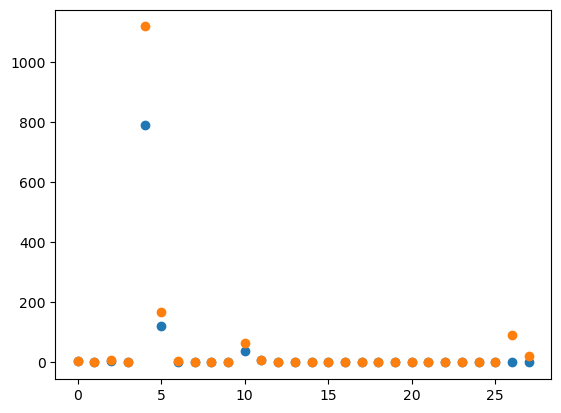

In [145]:
plt.plot(emulator.MSE(pd.DataFrame(X_test),pd.DataFrame(y_test)).detach().numpy(),'o')
plt.plot(((torch.sum((model.forward(X_test)[0]-y_test)**2,axis=0))/y_test.shape[0]).detach().numpy(),'o')


In [150]:
np.array([])/y_all

ValueError: Unable to coerce to Series, length must be 28: given 0